Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [18]:
# Створення numpy.ndarray зі значеннями кількості пасажирів
timeseries = df['Passengers'].values.astype(np.float32)

print(type(timeseries))
print(timeseries.dtype)
print(timeseries[:5])


<class 'numpy.ndarray'>
float32
[112. 118. 132. 129. 121.]


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [19]:
train_size = int(len(timeseries) * 0.67)

# time series (навчаємось на давніших, валідуємось - на новіших)
train = timeseries[:train_size]
val = timeseries[train_size:]

# Перевірка
print(f"Total: {len(timeseries)}")
print(f"train: {len(train)}")
print(f"val: {len(val)}")

print("\nTOP-5 train:", train[:5])
print("TOP 5 val:", val[:5])

Total: 144
train: 96
val: 48

TOP-5 train: [112. 118. 132. 129. 121.]
TOP 5 val: [315. 301. 356. 348. 355.]


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [20]:
import torch

def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback)])
        y.append(dataset[i + lookback])
    X = np.array(X)
    y = np.array(y)

    return torch.tensor(X).float(), torch.tensor(y).float().view(-1, 1)

In [21]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(val, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [22]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [23]:
model = AirModel(hidden_size=50, num_layers=1)
test_input = torch.tensor([[[112.]]])
test_output = model(test_input)
print("test:", test_output)

test: tensor([[[0.1269]]], grad_fn=<ViewBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [24]:
from torch.utils.data import TensorDataset, DataLoader

# Створення TensorDataset
train_dataset = TensorDataset(X_train, y_train)

# Створення DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

# Перевірка одного батча
X_batch, y_batch = next(iter(train_loader))

print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)

X_batch shape: torch.Size([8, 1])
y_batch shape: torch.Size([8, 1])


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [25]:
model = AirModel(hidden_size=50, num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses = []

In [26]:
for epoch in range(2000):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        yb = yb.squeeze(-1)
        output = model(xb)
        loss = loss_fn(output[:, -1], yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    losses.append(total_loss / len(train_loader))

    # Валідація раз на 100 епох
    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train.unsqueeze(-1))[:, -1]
            test_pred = model(X_test.unsqueeze(-1))[:, -1]

            train_rmse = torch.sqrt(loss_fn(train_pred, y_train))
            test_rmse = torch.sqrt(loss_fn(test_pred, y_test))

        print(f"Epoch {epoch+1}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 100: train RMSE 77.1618, test RMSE 243.2165
Epoch 200: train RMSE 71.4229, test RMSE 209.2840
Epoch 300: train RMSE 73.4368, test RMSE 198.2349
Epoch 400: train RMSE 75.1744, test RMSE 192.6468
Epoch 500: train RMSE 75.2963, test RMSE 192.3030
Epoch 600: train RMSE 77.3180, test RMSE 187.1692
Epoch 700: train RMSE 76.5031, test RMSE 189.1279
Epoch 800: train RMSE 75.1342, test RMSE 192.7612
Epoch 900: train RMSE 75.3933, test RMSE 192.0333
Epoch 1000: train RMSE 77.6158, test RMSE 186.4838
Epoch 1100: train RMSE 75.4953, test RMSE 191.7524
Epoch 1200: train RMSE 77.0072, test RMSE 187.9015
Epoch 1300: train RMSE 75.5321, test RMSE 191.6519
Epoch 1400: train RMSE 76.2168, test RMSE 189.8483
Epoch 1500: train RMSE 74.7618, test RMSE 193.8478
Epoch 1600: train RMSE 75.5200, test RMSE 191.6849
Epoch 1700: train RMSE 75.6965, test RMSE 191.2073
Epoch 1800: train RMSE 77.0221, test RMSE 187.8661
Epoch 1900: train RMSE 76.1740, test RMSE 189.9576
Epoch 2000: train RMSE 75.9220, test RMS

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

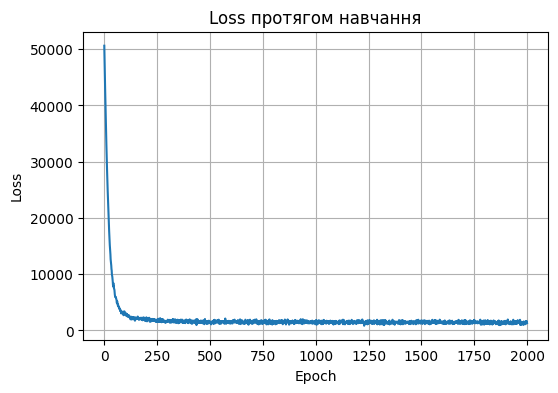

In [27]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Loss протягом навчання")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

/tmp/ipython-input-311553601.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1]
/tmp/ipython-input-311553601.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]


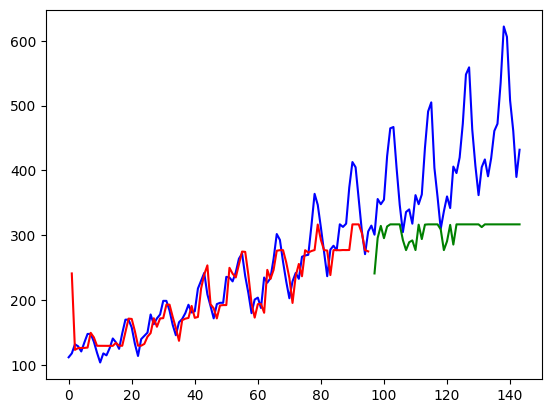

In [28]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [29]:
model_100 = AirModel(hidden_size=100, num_layers=1)
optimizer_100 = torch.optim.Adam(model_100.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses_100 = []
for epoch in range(1000):
    model_100.train()
    total_loss = 0
    for xb, yb in train_loader:
        output = model_100(xb)
        loss = loss_fn(output[:, -1], yb)
        loss.backward()
        optimizer_100.step()
        optimizer_100.zero_grad()
        total_loss += loss.item()
    losses_100.append(total_loss / len(train_loader))

    # Валідація раз на 100 епох
    if (epoch + 1) % 100 == 0:
        model_100.eval()
        with torch.no_grad():
            train_pred = model_100(X_train.unsqueeze(-1))[:, -1]
            test_pred = model_100(X_test.unsqueeze(-1))[:, -1]

            train_rmse = torch.sqrt(loss_fn(train_pred, y_train))
            test_rmse = torch.sqrt(loss_fn(test_pred, y_test))

        print(f"Epoch {epoch+1}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100: train RMSE 84.5456, test RMSE 258.2571
Epoch 200: train RMSE 79.3421, test RMSE 248.2030
Epoch 300: train RMSE 78.3293, test RMSE 245.9680
Epoch 400: train RMSE 76.2195, test RMSE 240.8217
Epoch 500: train RMSE 74.2371, test RMSE 235.0069
Epoch 600: train RMSE 73.3602, test RMSE 231.8798
Epoch 700: train RMSE 72.3113, test RMSE 227.2095
Epoch 800: train RMSE 71.6881, test RMSE 223.3235
Epoch 900: train RMSE 71.3855, test RMSE 220.5443
Epoch 1000: train RMSE 71.2254, test RMSE 218.2583


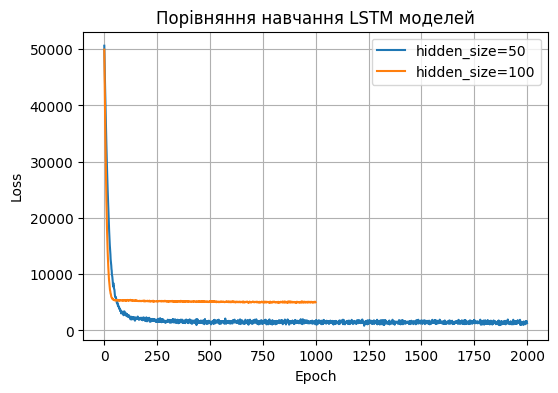

In [30]:
plt.figure(figsize=(6,4))
plt.plot(losses, label='hidden_size=50')
plt.plot(losses_100, label='hidden_size=100')
plt.title('Порівняння навчання LSTM моделей')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

На графіку можна бачити чітку різницю між графіками.
Збільшення hidden_size не гарантує кращого результату.


*   модель з hidden_size = 50 краще узагальнює дані
*   модель з hidden_size = 100 можливо переускладнена для цього обсягу даних,або гірше оптимізується (потрібен інший learning rate, регуляризація або менше епох)